In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib
from google.colab import drive

drive.mount('/content/gdrive')
dataset_url = "/content/gdrive/MyDrive/IMG_CLASSES"
data_dir = pathlib.Path(dataset_url)

Mounted at /content/gdrive


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

27186


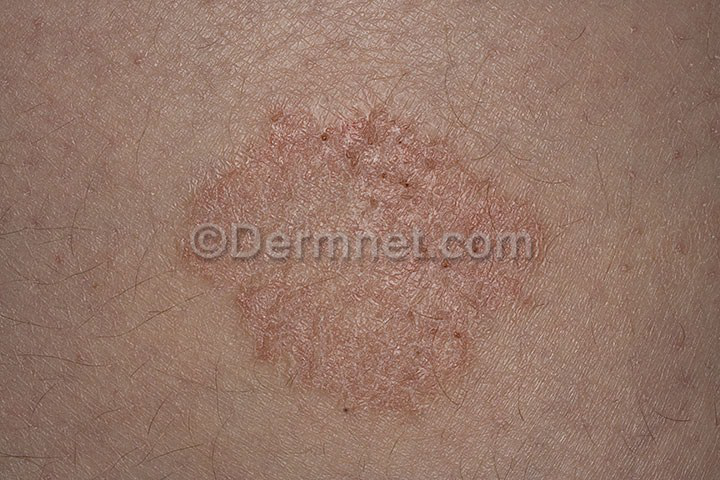

In [5]:
skinDrawsinnes = list(data_dir.glob('1. Eczema 1677/*'))
PIL.Image.open(str(skinDrawsinnes[0]))

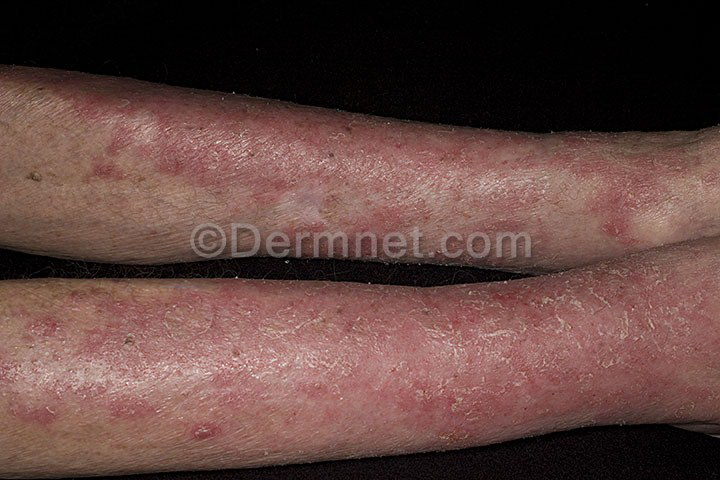

In [6]:
PIL.Image.open(str(skinDrawsinnes[1]))

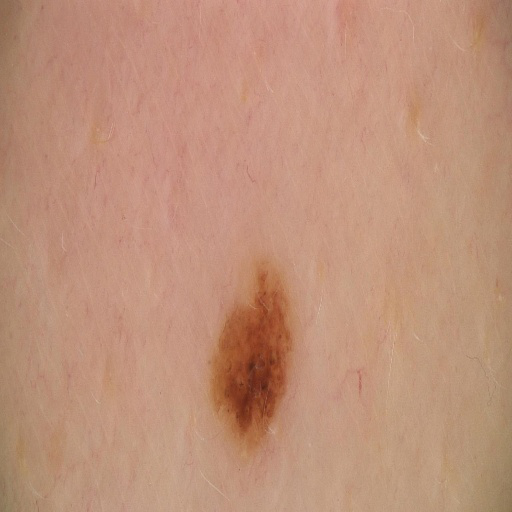

In [7]:
skinDrawsinnes2 = list(data_dir.glob('2. Melanoma 15.75k/*'))
PIL.Image.open(str(skinDrawsinnes2[0]))

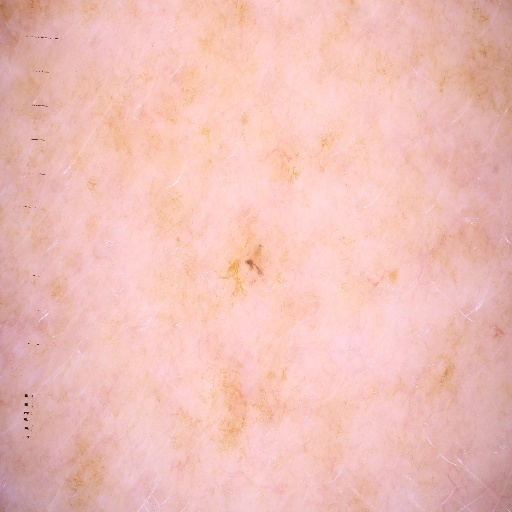

In [8]:
PIL.Image.open(str(skinDrawsinnes2[1]))

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27186 files belonging to 10 classes.
Using 21749 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27186 files belonging to 10 classes.
Using 5437 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '2. Melanoma 15.75k', '3. Atopic Dermatitis - 1.25k', '4. Basal Cell Carcinoma (BCC) 3323', '5. Melanocytic Nevi (NV) - 7970', '6. Benign Keratosis-like Lesions (BKL) 2624', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']


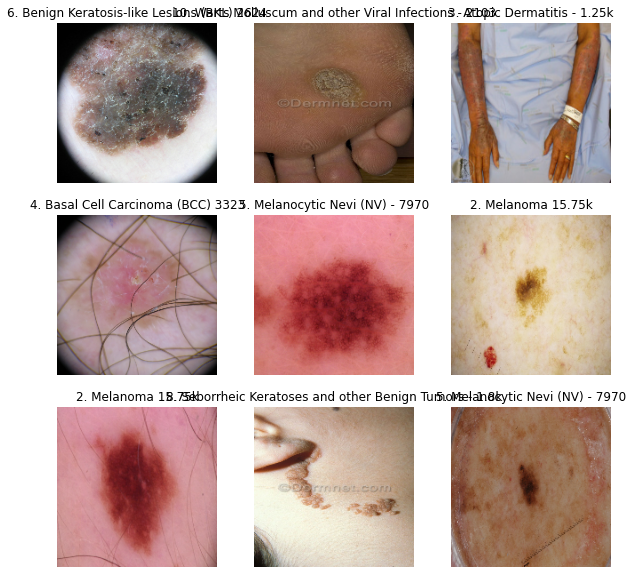

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.06290843 0.9982027


In [18]:
num_classes = 10

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
680/680 [==============================] - 1207s 2s/step - loss: 1.3886 - accuracy: 0.4910 - val_loss: 1.2076 - val_accuracy: 0.5345
Epoch 2/10
680/680 [==============================] - 693s 1s/step - loss: 1.0694 - accuracy: 0.5957 - val_loss: 0.9955 - val_accuracy: 0.6145
Epoch 3/10
680/680 [==============================] - 680s 1s/step - loss: 0.9541 - accuracy: 0.6421 - val_loss: 0.9949 - val_accuracy: 0.6241
Epoch 4/10
680/680 [==============================] - 683s 1s/step - loss: 0.8470 - accuracy: 0.6816 - val_loss: 0.9804 - val_accuracy: 0.6445
Epoch 5/10
680/680 [==============================] - 682s 1s/step - loss: 0.7483 - accuracy: 0.7206 - val_loss: 0.9027 - val_accuracy: 0.6732
Epoch 6/10
680/680 [==============================] - 683s 1s/step - loss: 0.6430 - accuracy: 0.7613 - val_loss: 0.9619 - val_accuracy: 0.6743
Epoch 7/10
680/680 [==============================] - 694s 1s/step - loss: 0.5338 - accuracy: 0.8038 - val_loss: 1.0529 - val_accuracy: 0.660

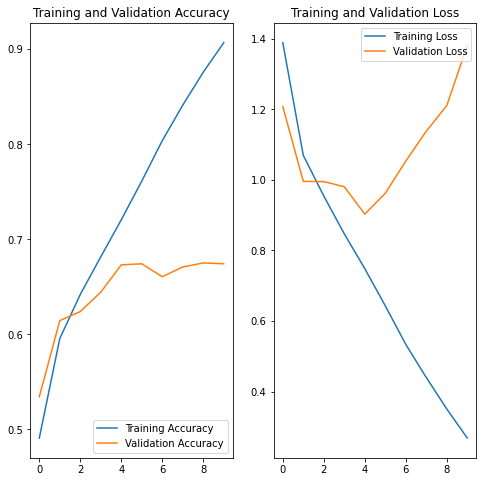

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

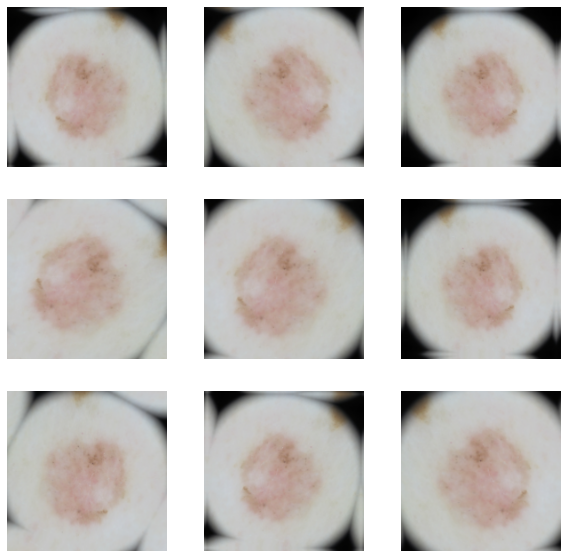

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
680/680 [==============================] - 813s 1s/step - loss: 1.5009 - accuracy: 0.4538 - val_loss: 1.2415 - val_accuracy: 0.5396
Epoch 2/15
680/680 [==============================] - 804s 1s/step - loss: 1.2354 - accuracy: 0.5433 - val_loss: 1.1213 - val_accuracy: 0.5713
Epoch 3/15
680/680 [==============================] - 789s 1s/step - loss: 1.1564 - accuracy: 0.5659 - val_loss: 1.0874 - val_accuracy: 0.5865
Epoch 4/15
680/680 [==============================] - 793s 1s/step - loss: 1.0809 - accuracy: 0.5927 - val_loss: 1.0998 - val_accuracy: 0.5770
Epoch 5/15
680/680 [==============================] - 803s 1s/step - loss: 1.0416 - accuracy: 0.6041 - val_loss: 1.1708 - val_accuracy: 0.5694
Epoch 6/15
680/680 [==============================] - 787s 1s/step - loss: 1.0108 - accuracy: 0.6158 - val_loss: 1.0277 - val_accuracy: 0.6138
Epoch 7/15
680/680 [==============================] - 783s 1s/step - loss: 0.9926 - accuracy: 0.6249 - val_loss: 0.9646 - val_accuracy: 0.6351

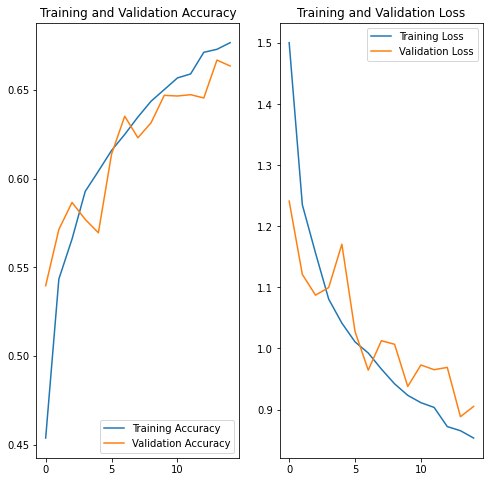

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:

drawsinnes_url = "https://images.everydayhealth.com/images/skin-beauty/eczema/what-is-eczema-atopic-dermatitis-symptoms-causes-diagnosis-treatment-prevention-01-722x406.jpg"
drawsinnes_path = tf.keras.utils.get_file('ezcema', origin=drawsinnes_url)

img = tf.keras.utils.load_img(
    drawsinnes_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

40960/25451 [================================================] - 0s 0us/step
This image most likely belongs to 7. Psoriasis pictures Lichen Planus and related diseases - 2k with a 52.76 percent confidence.


In [33]:
import pathlib

model.save("model.h5")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()

tflite_model_file = pathlib.Path("/content/tflite")
tflite_model_file.write_bytes(tflite_model)

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpedze4n9x/assets


INFO:tensorflow:Assets written to: /tmp/tmpedze4n9x/assets


In [34]:
ls model.h5


model.h5
